# Test

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hyperparameters
eta = 0.0001
beta1 = 0.9
beta2 = 0.999
threshold = (2 + 2 * beta1) / (eta * (1 - beta1))

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        # Use tanh as described in the paper
        activation = nn.Tanh()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 200),
            activation,
            nn.Linear(200, 200),
            activation,
            nn.Linear(200, 200),
            activation,
            nn.Linear(200, 200),
            activation,
            nn.Linear(200, 200),
            activation,
            nn.Linear(200, 10)
        )

    def forward(self, x):
        return self.layers(x)
    
    def forward(self, x):
        return self.layers(x)
    
device = torch.device("cuda")
model = MLP().to(device)

transform = transforms.ToTensor()
full_train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

subset_indices = list(range(12000))
train_subset = torch.utils.data.Subset(full_train_dataset, subset_indices)

print(f"Using a subset of {len(train_subset)} images.")

full_batch_loader = DataLoader(
    dataset = train_subset,
    batch_size = len(train_subset),
    shuffle = True
)

X_full, y_full = next(iter(full_batch_loader))
X_full = X_full.to(device)
y_full = y_full.to(device)

print(f"Data batch shape (X): {X_full.shape}") # Should be [1000, 1, 28, 28]
print(f"Data labels shape (y): {y_full.shape}") # Should be [1000]

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr = eta,
    betas = (beta1, beta2)
)

def get_preconditioned_sharpness(model, loss_fn, optimizer, X_batch, y_batch):
    def Hvp_fn(v): # Product H*v (Hessian * vector)
        model.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        grads1 = torch.autograd.grad(loss, model.parameters(), create_graph = True)
        grads1_flat = torch.cat([g.view(-1) for g in grads1])

        g_v_dot = (grads1_flat * v).sum()
        hvp = torch.autograd.grad(g_v_dot, model.parameters(), retain_graph = True)
        hvp_flat = torch.cat([h.view(-1) for h in hvp])

        return hvp_flat.detach()
    
    p_inv_flat_list = []
    eps = optimizer.param_groups[0]['eps']

    for param in model.parameters():
        if param in optimizer.state:
            state = optimizer.state[param]
            if 'exp_avg_sq' in state:
                v_t = state['exp_avg_sq']
                p_inv_t = 1 / (torch.sqrt(v_t) + eps)
                p_inv_flat_list.append(p_inv_t.view(-1))

    if not p_inv_flat_list:
        return 0
            
    p_inv_flat = torch.cat(p_inv_flat_list)

    num_params = p_inv_flat.size(0)
    v = torch.randn(num_params, device = X_batch.device)

    num_iterations = 10

    for _ in range(num_iterations):
        v = v / torch.norm(v)
        H_v = Hvp_fn(v)
        z = p_inv_flat * H_v
        eigenvalue = torch.dot(v, z)
        v = z

    return eigenvalue.item()

Using a subset of 12000 images.
Data batch shape (X): torch.Size([12000, 1, 28, 28])
Data labels shape (y): torch.Size([12000])


In [ ]:
train_losses = []
sharpness_values = []

model = MLP().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=eta, betas=(beta1, beta2))
n_steps = 1000

for step in range(n_steps):
    optimizer.zero_grad()
    y_pred = model(X_full)
    loss = loss_fn(y_pred, y_full)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if step > 0:
        sharpness = get_preconditioned_sharpness(model, loss_fn, optimizer, X_full, y_full)
        sharpness_values.append(sharpness)
    else:
        sharpness_values.append(0)
    
    if step % 50 == 0 or step == n_steps -1:
        print(f"Step {step}/{n_steps} | Loss: {loss.item():.4f} | Sharpness: {sharpness_values[-1]:.2f}")

print("Training finished")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Training Loss
ax1.plot(train_losses, label='Train Loss')
ax1.set_ylabel('Train Loss')
ax1.set_title(f'Full-Batch Adam on MNIST Subset (η={eta}, β1={beta1})')
ax1.legend()
ax1.grid(True)

# Preconditioned Sharpness
ax2.plot(range(n_steps), sharpness_values, label='Measured Preconditioned Sharpness')

ax2.axhline(y=threshold, color='r', linestyle='--', 
            label=f'Theoretical Threshold (38/η) = {threshold:.2f}')

ax2.set_xlabel('Step')
ax2.set_ylabel('Preconditioned Sharpness')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Not test

In [4]:
def run_experiment(eta, beta1, beta2, n_steps=1000):
    print(f"--- Running experiment: eta={eta}, beta1={beta1}, beta2={beta2} ---")
    
    model = MLP().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=eta, betas=(beta1, beta2))
    
    train_losses = []
    sharpness_values = []

    for step in range(n_steps):
        optimizer.zero_grad()
        y_pred = model(X_full)
        loss = loss_fn(y_pred, y_full)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if step > 0:
            # We pass the live model and optimizer to the measurement function
            sharpness = get_preconditioned_sharpness(model, loss_fn, optimizer, X_full, y_full)
            sharpness_values.append(sharpness)
        else:
            sharpness_values.append(0.0) # Step 0 has no optimizer state
        
        if step % 200 == 0 or step == n_steps - 1:
            print(f"  Step {step}/{n_steps} | Loss: {loss.item():.4f} | Sharpness: {sharpness_values[-1]:.2f}")

    return train_losses, sharpness_values

# Replicate Figure 1


--- Running experiment: eta=3e-05, beta1=0.9, beta2=0.999 ---
  Step 0/1000 | Loss: 2.3021 | Sharpness: 0.00
  Step 200/1000 | Loss: 1.2023 | Sharpness: 47308.55
  Step 400/1000 | Loss: 0.6304 | Sharpness: 51852.43
  Step 600/1000 | Loss: 0.4352 | Sharpness: 64770.09
  Step 800/1000 | Loss: 0.3273 | Sharpness: 75835.52
  Step 999/1000 | Loss: 0.2642 | Sharpness: 90540.55
--- Running experiment: eta=0.0001, beta1=0.9, beta2=0.999 ---
  Step 0/1000 | Loss: 2.3029 | Sharpness: 0.00
  Step 200/1000 | Loss: 0.4043 | Sharpness: 74127.37
  Step 400/1000 | Loss: 0.1946 | Sharpness: 130882.52
  Step 600/1000 | Loss: 0.0809 | Sharpness: 255036.78
  Step 800/1000 | Loss: 0.0266 | Sharpness: 331418.22
  Step 999/1000 | Loss: 0.0104 | Sharpness: 212992.94
--- Running experiment: eta=0.00032, beta1=0.9, beta2=0.999 ---
  Step 0/1000 | Loss: 2.3027 | Sharpness: 0.00
  Step 200/1000 | Loss: 0.1254 | Sharpness: 179960.81
  Step 400/1000 | Loss: 0.0115 | Sharpness: 101707.88
  Step 600/1000 | Loss: 0.00

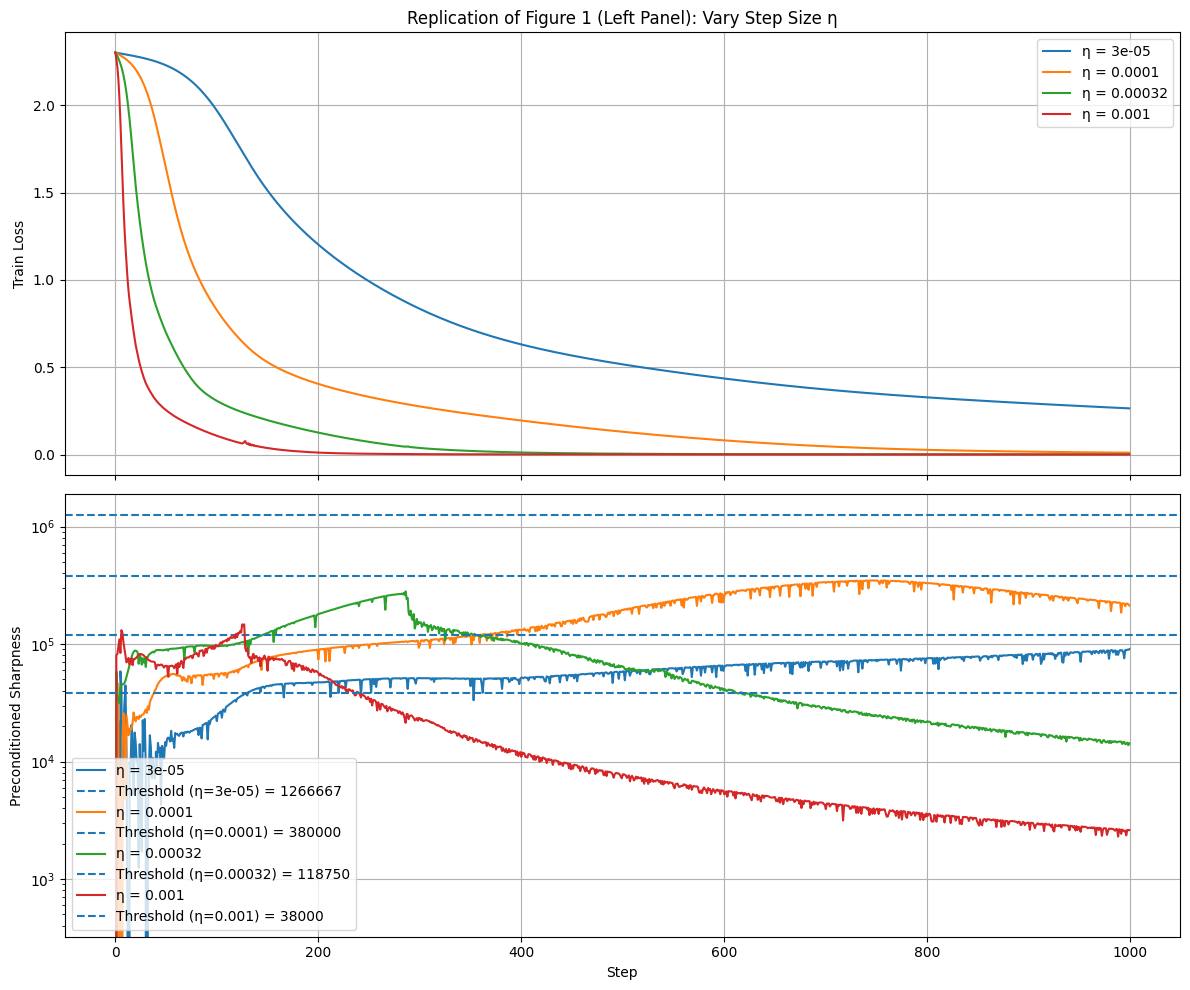

In [5]:
eta_list = [0.00003, 0.0001, 0.00032, 0.001]
beta1_fixed = 0.9
beta2_fixed = 0.999
n_steps = 1000

results_by_eta = {}

for eta_val in eta_list:
    threshold = (2 + 2 * beta1_fixed) / (eta_val * (1 - beta1_fixed))
    losses, sharpness = run_experiment(eta_val, beta1_fixed, beta2_fixed, n_steps)
    
    results_by_eta[eta_val] = {
        'losses': losses,
        'sharpness': sharpness,
        'threshold': threshold
    }

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for i, (eta_val, results) in enumerate(results_by_eta.items()):
    label = f'η = {eta_val}'
    
    ax1.plot(results['losses'], label=label)
    
    steps_to_plot = range(n_steps)
    ax2.plot(steps_to_plot, results['sharpness'], label=label)
    
    ax2.axhline(y=results['threshold'], linestyle='--', 
                label=f'Threshold (η={eta_val}) = {results["threshold"]:.0f}')

ax1.set_ylabel('Train Loss')
ax1.set_title('Replication of Figure 1 (Left Panel): Vary Step Size η')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Step')
ax2.set_ylabel('Preconditioned Sharpness')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()